0.05


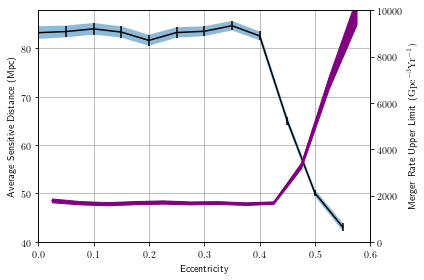

In [9]:
# sensitivity  + upper limit plot 
import h5py, numpy
import pylab
from pycbc.sensitivity import volume_montecarlo
from pycbc.conversions import mchirp_from_mass1_mass2
from pycbc.sensitivity import volume_to_distance_with_errors

f = h5py.File('./allinj10.hdf', 'r')
mc = mchirp_from_mass1_mass2(f['injections/mass1'][:], f['injections/mass2'][:])
ecc = f['injections/optimal_snr_2'][:]
foundf = f['found_after_vetoes/injection_index'][:]
missedf = f['missed/after_vetoes'][:]
dist = f['injections/distance'][:]
ifar = f['found_after_vetoes/ifar'][:]

time = f.attrs['foreground_time']

minifar = 100
missed = numpy.concatenate([missedf, foundf[ifar < minifar]])
found = foundf[ifar >= minifar]

ewidth = 0.05
ec = numpy.arange(0, ecc.max(), ewidth)

vs = []
ves = []
for e in ec:
    l = numpy.where((ecc > e) & (ecc < e + ewidth))[0]
    fl = numpy.intersect1d(l, found)
    ml = numpy.intersect1d(l, missed)

    v, ve = volume_montecarlo(dist[fl], dist[ml], mc[fl], mc[ml],
                              'chirp_distance', 'uniform', 'chirp_distance')
    vs.append(v)
    ves.append(ve)
    
vs = numpy.array(vs)
ves = numpy.array(ves)
d, dlow, dhigh = volume_to_distance_with_errors(vs, ves)

pylab.rc('text', usetex=True)

pylab.figure()
pylab.fill_between(ec, d-dlow, d+dhigh, alpha=0.5)
pylab.errorbar(ec, d, yerr=(dlow, dhigh), color='black')


pylab.xlim(0, 0.6)
pylab.ylim(ymin=40)
pylab.ylabel('Average Sensitive Distance (Mpc)', fontsize=10)
pylab.xlabel('Eccentricity', fontsize=10)
pylab.grid()

# false alarm rate in years of the loudest event (should fill in with more precision)
minifar = 0.5
missed = numpy.concatenate([missedf, foundf[ifar < minifar]])
found = foundf[ifar >= minifar]

vs = []
ves = []
for e in ec:
    l = numpy.where((ecc > e) & (ecc < e + ewidth))[0]
    fl = numpy.intersect1d(l, found)
    ml = numpy.intersect1d(l, missed)

    v, ve = volume_montecarlo(dist[fl], dist[ml], mc[fl], mc[ml],
                              'chirp_distance', 'uniform', 'chirp_distance')
    vs.append(v)
    ves.append(ve)
    
vs = numpy.array(vs)
ves = numpy.array(ves)

ax2 = pylab.twinx()
pylab.sca(ax2)

tyear = time / 3.154e+7
vt = vs * tyear
vte = ves * tyear
ul = 2.303 / vt * 1e9 # Get units in per Gpc per Yr
elow = 2.303 / (vt + vte) * 1e9
ehigh = 2.303 / (vt - vte) * 1e9
pylab.fill_between(ec+ewidth/2.0, elow, ehigh, color='purple')
pylab.plot(ec+ewidth/2.0, ul, color='purple')
print ewidth
pylab.ylim(0, 10000)
pylab.ylabel('Merger Rate Upper Limit ($\\textrm{Gpc}^{-3}\\textrm{Yr}^{-1})$')
pylab.tight_layout()
pylab.savefig('rate.pdf')

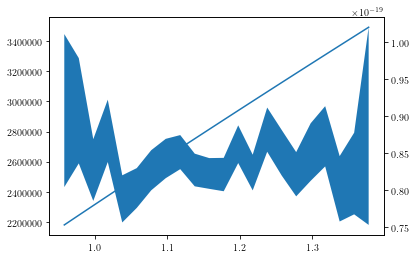

In [4]:
# check dependence on chirp mass
import h5py, numpy
from pycbc.sensitivity import volume_montecarlo
from pycbc.conversions import mchirp_from_mass1_mass2
from pycbc.sensitivity import volume_to_distance_with_errors

f = h5py.File('./allinj10.hdf', 'r')
mc = mchirp_from_mass1_mass2(f['injections/mass1'][:], f['injections/mass2'][:])
ecc = f['injections/optimal_snr_2'][:]
foundf = f['found_after_vetoes/injection_index'][:]
missedf = f['missed/after_vetoes'][:]
dist = f['injections/distance'][:]
ifar = f['found_after_vetoes/ifar'][:]

time = f.attrs['foreground_time']

minifar = 100
missed = numpy.concatenate([missedf, foundf[ifar < minifar]])
found = foundf[ifar >= minifar]

ewidth = 0.02
ec = numpy.arange(mc.min(), mc.max(), ewidth)

vs = []
ves = []
for e in ec:
    l = numpy.where((ecc < 0.4) & (mc > e) & (mc < e + ewidth))[0]
    fl = numpy.intersect1d(l, found)
    ml = numpy.intersect1d(l, missed)

    v, ve = volume_montecarlo(dist[fl], dist[ml], mc[fl], mc[ml],
                              'chirp_distance', 'uniform', 'chirp_distance')
    vs.append(v)
    ves.append(ve)
    
vs = numpy.array(vs)
ves = numpy.array(ves)

from pycbc.waveform.spa_tmplt import spa_amplitude_factor
from pycbc.conversions import mass1_from_mchirp_q
ms = mass1_from_mchirp_q(ec, 1.0)
amp = numpy.array([spa_amplitude_factor(mass1=m, mass2=m, 
                                        spin1z=0, spin2z=0) for m in ms])
amp = abs(amp)

import pylab
vs /= (amp / amp.mean())**3.0
ves /=  (amp / amp.mean())**3.0
#print mc.max(), mc.min()
#print mchirp_from_mass1_mass2(1.33, 1.33)

pylab.fill_between(ec, vs-ves, vs+ves)
pylab.twinx()
pylab.plot(ec, amp)

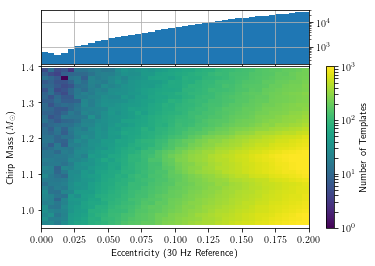

In [5]:
# template bank plots
from matplotlib.colors import LogNorm

f = h5py.File('./ebank.hdf', 'r')

pylab.rc('text', usetex=True)
m1 = f['mass1'][:]
m2 = f['mass2'][:]
e = f['eccentricity'][:]
inc = f['inclination'][:]
lo = f['long_asc_nodes'][:]
mc = mchirp_from_mass1_mass2(m1, m2)
#pylab.scatter(mc, e, s=0.01, rasterized=True)

def align_axis_x(ax, ax_target):
    """Make x-axis of `ax` aligned with `ax_target` in figure"""
    posn_old, posn_target = ax.get_position(), ax_target.get_position()
    ax.set_position([posn_target.x0, posn_old.y0, posn_target.width, posn_old.height])


fig, (ax1, ax2) = pylab.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]})

pylab.sca(ax1)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
pylab.hist(e, bins=40, rasterized=True)
pylab.ylim(200, 30000)
pylab.yscale('log')
pylab.grid()

pylab.sca(ax2)
pylab.hist2d(e, mc, bins=40, norm=LogNorm(vmin=1, vmax=1000), rasterized=True)
c = pylab.colorbar()
c.set_label('Number of Templates')

pylab.subplots_adjust(wspace=None, hspace=.02)
align_axis_x(ax1, ax2)
pylab.ylabel('Chirp Mass ($M_\odot$)')
pylab.ylim(0.95, 1.40)
pylab.xlim(0, 0.2)
pylab.xlabel('Eccentricity (30 Hz Reference)')
pylab.savefig('bank.pdf')